<a href="https://colab.research.google.com/github/FrankAyalaC/sensitivity_analysis_WW3/blob/main/Plotting_error_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import os
from datetime import datetime,timedelta
import glob as glob
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm


newparams = { 'axes.grid': False,
             'lines.linewidth': 1.5, 'lines.linewidth': 2,
             'ytick.labelsize':15,
             'xtick.labelsize':15,
             'axes.labelsize':16,
             'axes.titlesize':18,
            'legend.fontsize':14,
             'figure.titlesize':16,
             'font.family':'Helvetica Light'}
plt.rcParams.update(newparams)

from datetime import datetime,timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_track=pd.read_csv('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/df_track.csv',
                     sep=' ',names=['date','lat','lon','wind','id','color','cat'])

In [4]:
df_track=df_track.set_index('date')
df_interest=df_track.iloc[:17]

In [5]:
data_array=df_interest.index
cat_array=df_interest.cat.values
dates_org=pd.to_datetime(data_array)
data_str=dates_org.strftime('%H %d/%m/%y')

In [6]:
def get_index_positions(list_of_elems, element):
  ''' Returns the indexes of all occurrences of give element in
  the list- listOfElements '''
  index_pos_list = []
  index_pos = 0
  while True:
      try:
          # Search for item in list from indexPos to the end of list
          index_pos = list_of_elems.index(element, index_pos)
          # Add the index position in list
          index_pos_list.append(index_pos)
          index_pos += 1
      except ValueError as e:
          break
  return index_pos_list

In [7]:
categories=['H1','H2','H3','H4','H5']
dic_cats={}

In [8]:
for cat in categories:
  dic_cats[cat]=get_index_positions(cat_array.tolist(),cat)  

In [9]:
ds_specs=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/efth_spec.npz',
                 allow_pickle=True)
ds_specs_v2=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/efth_spec_v2.npz',
                 allow_pickle=True)

In [10]:
specs_sw3=ds_specs['sw3'].flatten()[0]
specs_sw4=ds_specs_v2['sw4'].flatten()[0]
specs_sw6=ds_specs_v2['sw6'].flatten()[0]

In [11]:
freqs=[0.042, 0.0462, 0.05082001, 0.05590201, 0.06149221, 0.06764144,
    0.07440558, 0.08184613, 0.09003075, 0.09903383, 0.1089372, 0.1198309,
    0.131814, 0.1449955, 0.159495, 0.1754445, 0.192989, 0.2122879, 0.2335167,
    0.2568683, 0.2825552, 0.3108107, 0.3418918, 0.376081, 0.4136891,
    0.455058, 0.5005639, 0.5506203, 0.6056823, 0.6662505]

In [12]:
def arranging_axes(ax,xlabel):
  ax.set_xticks(np.linspace(0,36,5))
  ax.set_xticklabels(list(map(str,np.linspace(0,360,5,dtype=int))))
  ax.set_yticks(np.arange(0,31,10))
  ax.set_yticklabels(np.round([freqs[0],freqs[9],freqs[19],freqs[29]],2))
  if xlabel==1:
    ax.set_xlabel('Direction [°]') 

In [168]:
metadata={'percent':'+50','switch':'ST4','name_param':'SINTHP','idx_time':1,'quad':1,'cat_array':cat_array,
          'freqs':np.array(freqs),'dirs':np.radians(np.arange(0,360,10)),'dic_cats':dic_cats}

In [169]:
def max_min_values(function):
  def wrapper(arg1):
    val1,val2,val3,val4,val5 = list(function(arg1))
    min_values_wdef=[min([np.nanmin(obj),np.nanmin(val1)]) for obj in val2]
    max_values_wdef=[max([np.nanmax(obj),np.nanmax(val1)]) for obj in val2]
    min_values=list(map(lambda x: np.nanmin(x),val2))
    max_values=list(map(lambda x: np.nanmax(x),val2))
    dict_computations={'def':val1,'objs':val2,'results':val3,'results_mean':val4,'porc_means':val5,'min_wdef':min_values_wdef,
                'max_wdef':max_values_wdef,'min':min_values,'max':max_values}
    return dict_computations
  return wrapper

In [170]:
class spec_data:
  def __init__(self,data_spec,dic_met):
    self.data = data_spec
    self.dic_met = dic_met
    self.quadrants=['Center','Quadrant I','Quadrant II','Quadrant III','Quadrant IV']
    self.percentages=['-10','-30','-50','+10','+30','+50']

  @max_min_values
  def computing_one(self):
    self.name=self.dic_met['name_param']
    self.def_name=self.name+'/0'
    self.default=np.reshape(self.data[self.def_name][:85,:,:],(17,5,30,36))[self.dic_met['idx_time'],self.dic_met['quad'],:,:]
    self.objs=[np.reshape(self.data[param][:85,:,:],(17,5,30,36))[self.dic_met['idx_time'],self.dic_met['quad'],:,:] \
               for param in self.data.keys() if param != self.def_name and param[:param.find('/')]==self.name]
    self.results=[((obj-self.default)/(np.nanmax(self.default)))*100 for obj in self.objs]  # Without abs             
    self.results_mean=sum(self.results)/6
    self.perc_dif_means=[((np.mean(obj)-np.mean(self.default))/(np.mean(self.default)))*100 
                         for obj in self.objs]
                  
    return self.default,self.objs,self.results,self.results_mean,self.perc_dif_means

In [171]:
class Basic_Plot(spec_data):
  def __init__(self,data_spec,dic_met,dic,fig,axes,path_save):
    super().__init__(data_spec,dic_met)
    self.dic=dic
    self.fig=fig
    self.axes=axes
    self.path_save=path_save
    self.idx_percent=self.percentages.index(self.dic_met['percent'])
    self.r,self.theta = np.meshgrid(self.dic_met['freqs'], self.dic_met['dirs'])
    plt.setp(self.axes,rmin=0,rmax=1,theta_direction=(-1),theta_zero_location=('N'))
    plt.subplots_adjust(wspace=0.3)

  def plot_obj(self,ax,idx,y_title,common_bar,shared=False):
    if common_bar:
      self.cf=ax.contourf(self.theta,self.r,self.dic['objs'][idx].T,levels=50,vmin=min(self.dic['min']),
                             vmax=max(self.dic['max']),cmap='magma_r')
    else:
      self.cf=ax.contourf(self.theta,self.r,self.dic['objs'][idx].T,levels=50,vmin=self.dic['min_wdef'][idx],
                             vmax=self.dic['max_wdef'][idx],cmap='magma_r')
    ax.set_rlim([0,0.2])
    ax.set_xticks(np.radians(np.arange(0,360,90)))
    
    ax.set_title('Default' + self.percentages[idx] + '%',y=y_title)
    if not shared:
      ax.set_ylabel(data_str[self.dic_met['idx_time']],labelpad=40)
    return ax,self.cf
  
  def plot_def(self,ax,y_title,common_bar,shared=True):
    if common_bar:
      self.cf=ax.contourf(self.theta,self.r,np.array(self.dic['def']).T,levels=50,vmin=self.dic['min_wdef'][self.idx_percent],
                    vmax=self.dic['max_wdef'][self.idx_percent],cmap='magma_r')
    else:
      self.cf=ax.contourf(self.theta,self.r,np.array(self.dic['def']).T,levels=50,vmin=np.array(self.dic['def']).min(),
                    vmax=np.array(self.dic['def']).max(),cmap='magma_r')
    
    ax.set_title('Default',y=y_title)
    ax.set_rlim([0,0.2])
    ax.set_xticks(np.radians(np.arange(0,360,90)))
    if not shared:
      ax.set_ylabel(data_str[self.dic_met['idx_time']],labelpad=40)
    return ax,self.cf

  def plot_result(self,ax,idx,y_title,common_bar,shared=False):
    if common_bar:
      self.norm = colors.TwoSlopeNorm(vmin=np.array(self.dic['results']).min(), 
                                    vcenter=0, vmax=np.array(self.dic['results']).max())
    else:
      self.norm = colors.TwoSlopeNorm(vmin=self.dic['results'][idx].min(), 
                                    vcenter=0, vmax=self.dic['results'][idx].max())
    self.cf=ax.contourf(self.theta,self.r,np.array(self.dic['results'][idx]).T,levels=50,norm=self.norm,cmap='RdBu_r')
    ax.set_title(r'$\frac{(Default'+self.percentages[idx]+'\%)- Default}{\max (Default)}$',y=y_title)
    ax.set_rlim([0,0.2])
    ax.set_xticks(np.radians(np.arange(0,360,90)))
    if not shared:
      ax.set_ylabel(data_str[self.dic_met['idx_time']],labelpad=40)
    return ax,self.cf

  def plot_result_mean(self,ax,y_title,shared):  
    self.norm = colors.TwoSlopeNorm(vmin=self.dic['results_mean'].min(), 
                                    vcenter=0, vmax=self.dic['results_mean'].max())
    self.cf=ax.contourf(self.theta,self.r,np.array(self.dic['results_mean']).T,levels=50,norm=self.norm,cmap='RdBu_r')
    ax.set_title(r'Mean map of normalized differences',y=y_title)
    ax.set_rlim([0,0.2])
    ax.set_xticks(np.radians(np.arange(0,360,90)))
    if not shared:
      ax.set_ylabel(data_str[self.dic_met['idx_time']],labelpad=40)
    return ax,self.cf

  def horiz_colorbar(self,ax,cf,pad,label):
    self.cax= self.fig.add_axes([ax.get_position().x0,ax.get_position().y0-pad,
                                  0.5,0.02])
    self.cbar=plt.colorbar(cf,cax=self.cax,orientation="horizontal")
    self.cbar.set_label(label,fontsize=17)
    self.cbar.ax.tick_params(labelsize=16)

  def vert_colorbar(self,ax,cf,pad,width,label):
    self.cax= self.fig.add_axes([ax.get_position().x1+pad,ax.get_position().y0,
                                  width,ax.get_position().height])
    self.cbar=plt.colorbar(cf,cax=self.cax,orientation="vertical")
    self.cbar.set_label(label,fontsize=17)
    return self.cbar

  def plot_final(self):
        
    self.ax1,self.cf1=self.plot_obj(self.axes[0],self.idx_percent,1.13,False)
    self.ax2,self.cf2=self.plot_def(self.axes[1],1.13,True)
    self.ax3,self.cf3=self.plot_result(self.axes[2],self.idx_percent,1.13,False,True)
    self.horiz_colorbar(self.ax1,self.cf2,0.15,r'Energy [$m^{2}/Hz$]')
    self.vert_colorbar(self.ax3,self.cf3,0.03,0.01,r'Normalized difference [%]')

    plt.suptitle('Example for category ' + self.dic_met['cat_array'][self.dic_met['idx_time']] + ' - parameter '+ self.dic_met['name_param'] + ' - ' + 
                 self.quadrants[self.dic_met['quad']]+ ' - '+self.dic_met['switch'],fontsize=18,y=1.05)
    plt.savefig(self.path_save+'one_variation_example.png',dpi=1000,bbox_inches='tight',pad_inches=0.05)
    plt.show()

In [172]:
obj1=spec_data(specs_sw3,metadata)
dic_res=obj1.computing_one()

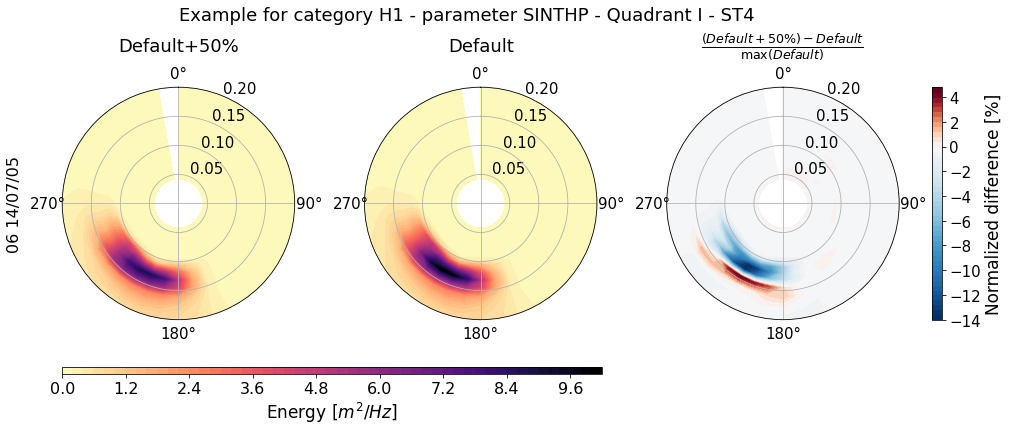

In [173]:
fig,axes=plt.subplots(1,3,figsize=(15,5),subplot_kw=dict(projection='polar'))
path_basic='/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/examples/'
bp=Basic_Plot(specs_sw3,metadata,dic_res,fig,axes,path_basic)
bp.plot_final()

In [174]:
class Medium_Plot(Basic_Plot):
  def __init__(self,data_spec,dic_met,dic,fig,path_save):
    super().__init__(data_spec,dic_met,dic,fig,axes,path_save)

  def plot_def_variations(self):
    self.fig,self.axes=plt.subplots(1,6,figsize=(18,3),subplot_kw=dict(projection='polar'))
    for idx in range(len(self.dic['results'])):
      self.ax_def=self.axes[idx]
      plt.setp(self.ax_def,rmin=0,rmax=1,theta_direction=(-1),theta_zero_location=('N'))
      if idx==0:
        self.ax_def,self.cf_def=super().plot_obj(self.ax_def,idx,1.2,True,False)
      else:
        self.ax_def,self.cf_def=super().plot_obj(self.ax_def,idx,1.2,True,True)
    self.normalizer=colors.Normalize(min(self.dic['min']),max(self.dic['max']))
    self.map=cm.ScalarMappable(norm=self.normalizer,cmap='magma_r')
    super().vert_colorbar(self.ax_def,self.map,0.03,0.008,r'Energy [$m^{2}/Hz$]')
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(self.path_save+'all_variations_example_1.png',dpi=1000,bbox_inches='tight',pad_inches=0.05)

  def plot_res_variations(self):
    self.fig,self.axes=plt.subplots(1,6,figsize=(18,3),subplot_kw=dict(projection='polar'))
    for idx in range(len(self.dic['results'])):
      self.ax_dif=self.axes[idx]
      plt.setp(self.ax_dif,rmin=0,rmax=1,theta_direction=(-1),theta_zero_location=('N'))
      if idx==0:
        self.ax_dif,self.cf_dif=super().plot_result(self.ax_dif,idx,1.3,True,False)
      else:
        self.ax_dif,self.cf_dif=super().plot_result(self.ax_dif,idx,1.3,True,True)
    self.normalizer=colors.TwoSlopeNorm(vmin=np.array(self.dic['results']).min(),vcenter=0,vmax=np.array(self.dic['results']).max())
    self.map=cm.ScalarMappable(norm=self.normalizer,cmap='RdBu_r')
    super().vert_colorbar(self.ax_dif,self.map,0.03,0.008,r'Norm. difference [%]')
    plt.subplots_adjust(wspace=0.6)
    plt.savefig(self.path_save+'all_variations_example_3.png',dpi=1000,bbox_inches='tight',pad_inches=0.05)

  def plot_default(self):
    self.fig,self.ax_d=plt.subplots(1,1,figsize=(2.2,2.2),subplot_kw=dict(projection='polar'))
    plt.setp(self.ax_d,rmin=0,rmax=1,theta_direction=(-1),theta_zero_location=('N'))
    self.ax_d,self.cf_d=super().plot_def(self.ax_d,1.2,False,False)
    super().vert_colorbar(self.ax_d,self.cf_d,0.25,0.07,r'Energy [$m^{2}/Hz$]')
    plt.savefig(self.path_save+'all_variations_example_2.png',dpi=1000,bbox_inches='tight',pad_inches=0.05)

  def plot_mean(self):
    self.fig,self.ax_m=plt.subplots(1,1,figsize=(2.2,2.2),subplot_kw=dict(projection='polar'))
    plt.setp(self.ax_m,rmin=0,rmax=1,theta_direction=(-1),theta_zero_location=('N'))
    self.ax_m,self.cf_m=super().plot_result_mean(self.ax_m,1.2,False)
    super().vert_colorbar(self.ax_m,self.cf_m,0.25,0.07,r'Norm. difference [%]')
    plt.savefig(self.path_save+'all_variations_example_4.png',dpi=1000,bbox_inches='tight',pad_inches=0.05)
    
  def plot_final(self):
    self.plot_def_variations()
    self.plot_default()
    self.plot_res_variations()
    self.plot_mean()

In [175]:
metadata['idx_time']=12
obj2=spec_data(specs_sw3,metadata)
dic_res=obj2.computing_one()

In [176]:
fig=plt.figure(figsize=(18,12))
path_all='/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/examples/'
mp=Medium_Plot(specs_sw3,metadata,dic_res,fig,path_all)

<Figure size 1296x864 with 0 Axes>

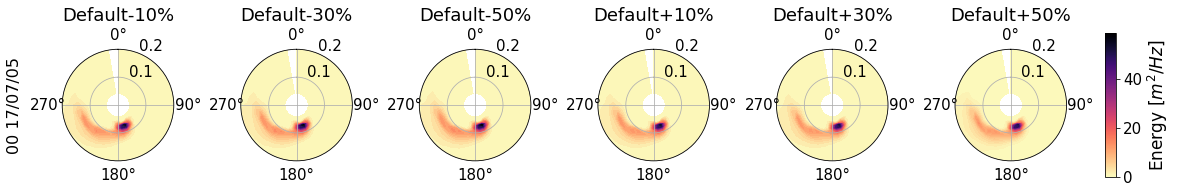

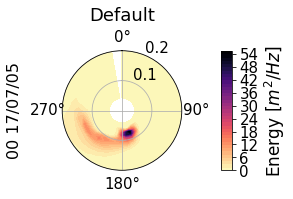

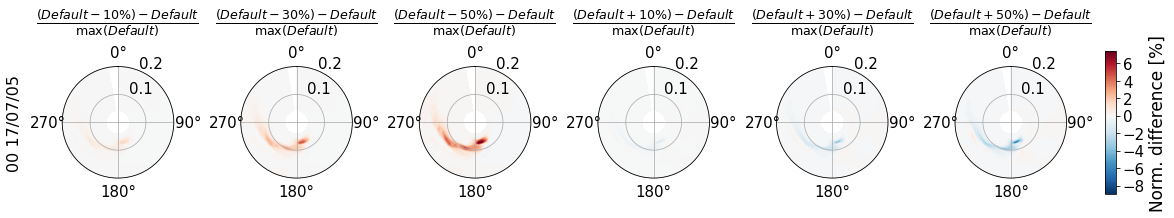

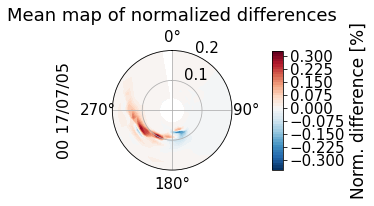

In [177]:
mp.plot_final()

In [178]:
def colorbar(data,cax):
  normalizer=colors.TwoSlopeNorm(vmin=np.nanmin(data),vcenter=0,vmax=np.nanmax(data))
  map=cm.ScalarMappable(norm=normalizer,cmap='RdBu_r')
  cbar=plt.colorbar(map,cax=cax,orientation="vertical",pad=0.12)
  cbar.set_label(r'Normalized difference [%]',fontsize=17)
  cbar.ax.tick_params(labelsize=16)

In [180]:
class Advanced_Plot:
  def __init__(self,data_spec,dic_met,path_save):
    self.data_spec=data_spec
    self.dic_met=dic_met
    self.path_save=path_save
    self.cats=np.unique(self.dic_met['cat_array'])
    self.r,self.theta = np.meshgrid(self.dic_met['freqs'], self.dic_met['dirs'])
    
  def data_per_cat(self,cat):
    self.n_rows=int(len(self.dic_met['dic_cats'][cat]))
    self.values=np.ones((self.n_rows,5,30,36))
    for idx,element in enumerate(self.dic_met['dic_cats'][cat]):
      for col in range(5):
        self.dic_met['idx_time']=element
        self.dic_met['quad']=col
        obj=spec_data(specs_sw3,self.dic_met)
        self.dic_res=obj.computing_one()
        self.values[idx,col,:,:]=self.dic_res['results_mean']
    return self.values

  def plot_one_error_map(self,axes,idx,col,element,cat):
    plt.setp(axes,rmin=0,rmax=0.2,theta_direction=(-1),theta_zero_location=('N'))
    self.norm = colors.TwoSlopeNorm(vmin=np.nanmin(self.data_per_cat(cat)), 
                                    vcenter=0, vmax=np.nanmax(self.data_per_cat(cat))) 
    
    if idx>=5:
      ax_idx=idx-5
    else:
      ax_idx=idx

    if axes.ndim==2:
      axes=axes[ax_idx][col]
    else:
      axes=axes[col]

    self.cf=axes.contourf(self.theta,self.r,np.array(self.data_per_cat(cat)[idx,col,:,:]).T, levels=50,norm=self.norm,cmap='RdBu_r') 
    axes.set_xticks(np.radians(np.arange(0,360,90)))
    axes.set_rlim([0,0.2])


    if ax_idx==0:
      if col==0:
        axes.set_title('Center',y=1.2)             
      elif 1<=col<=3:
        s='I'*col
        axes.set_title(f'Quadrant {s}',y=1.2)
      else:
        axes.set_title('Quadrant IV',y=1.2)
    if col==0:
      axes.set_ylabel(data_str[element],labelpad=40)
    return self.cf

  def plotting_diff_maps(self,cat):
    self.data=self.data_per_cat(cat)
    self.n=int(np.shape(self.data)[0])

    if self.n<=4:
      self.fig,self.axes=plt.subplots(self.n,5,figsize=(15,self.n*3),subplot_kw=dict(projection='polar'))
      for idx,element in enumerate(self.dic_met['dic_cats'][cat]):
        for col in range(5):
          self.cf=self.plot_one_error_map(self.axes,idx,col,element,cat) 
      self.fig.tight_layout() 
      if self.axes.ndim==2:
        self.cax2= self.fig.add_axes([self.axes[-1][-1].get_position().x1+0.04,
                                      (self.axes[-1][-1].get_position().y0+self.axes[-1][-1].get_position().y1)/2,0.015,
                                      (self.n-1)*self.axes[-1][-1].get_position().height*1.46])
        self.fig.suptitle('Normalized differences maps - category '+cat+ ' - '+ \
                        self.dic_met['name_param']+ ' - '+self.dic_met['switch'],y=1.02,fontsize=18)
      else:
        self.cax2= self.fig.add_axes([self.axes[-1].get_position().x1+0.04,
                                      self.axes[-1].get_position().y0,0.015,self.axes[-1].get_position().height])
        self.fig.suptitle('Normalized differences maps - category '+cat+ ' - '+ \
                        self.dic_met['name_param']+ ' - '+self.dic_met['switch'],y=1.09,fontsize=18)
      colorbar(self.data_per_cat(cat),self.cax2)

      
      self.fig.savefig(self.path_save+self.dic_met['switch']+'/'+self.dic_met['name_param']+'_'+cat+'_diff_maps.png',
          dpi=1000,bbox_inches='tight',pad_inches=0.05)
    else:
      self.fig,self.axes=plt.subplots(5,5,figsize=(15,15),subplot_kw=dict(projection='polar'))
      self.fig_other,self.axes_other=plt.subplots(int(np.shape(self.data)[0]-5),5,
                                                  figsize=(15,int(np.shape(self.data)[0]-5)*3),
                                                  subplot_kw=dict(projection='polar'))
      for idx,element in enumerate(self.dic_met['dic_cats'][cat]):
        for col in range(5):
          if idx<=4:
            self.plot_one_error_map(self.axes,idx,col,element,cat) 
          else:
            self.plot_one_error_map(self.axes_other,idx,col,element,cat) 
      self.fig.tight_layout() 
      self.fig_other.tight_layout() 

      self.cax_init= self.fig.add_axes([self.axes[-1][-1].get_position().x1+0.04,
                                        (self.axes[-1][-1].get_position().y0+self.axes[-1][-1].get_position().y1)/2,
                        0.015,(4)*self.axes[-1][-1].get_position().height*1.46])
      colorbar(self.data_per_cat(cat),self.cax_init)

      self.cax_end= self.fig_other.add_axes([self.axes_other[-1][-1].get_position().x1+0.04,
                                             (self.axes_other[-1][-1].get_position().y0+self.axes_other[-1][-1].get_position().y1)/2,
                                              0.015,(3)*self.axes[-1][-1].get_position().height*1.8])
      colorbar(self.data_per_cat(cat),self.cax_end)

      self.fig.suptitle('Normalized differences maps - category '+cat+ ' - '+ \
                        self.dic_met['name_param']+ ' - '+self.dic_met['switch'],y=1.02,fontsize=18)
      self.fig_other.suptitle('Normalized differences maps - category '+cat+ ' - '+ \
                        self.dic_met['name_param']+ ' - '+self.dic_met['switch'],y=1.02,fontsize=18)
      self.fig.savefig(self.path_save+self.dic_met['switch']+'/'+self.dic_met['name_param']+'_'+cat+'_diff_maps.png',
           dpi=1000,bbox_inches='tight',pad_inches=0.05)
      self.fig_other.savefig(self.path_save+self.dic_met['switch']+'/'+self.dic_met['name_param']+'_'+cat+'_diff_maps_2.png',
           dpi=1000,bbox_inches='tight',pad_inches=0.05)

In [181]:
root_path='/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/'
ap=Advanced_Plot(specs_sw3,metadata,root_path)

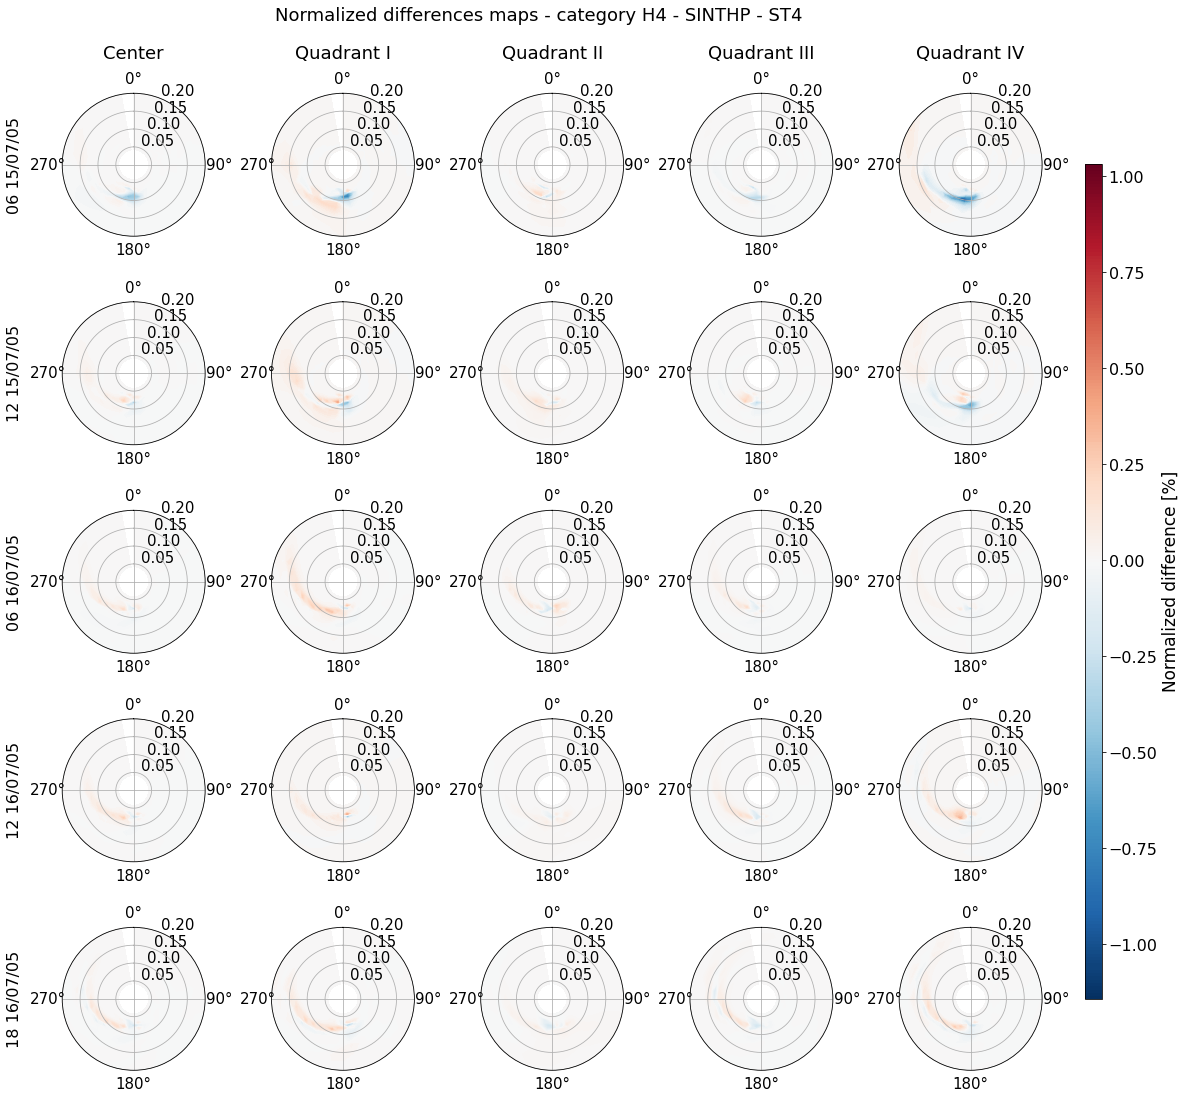

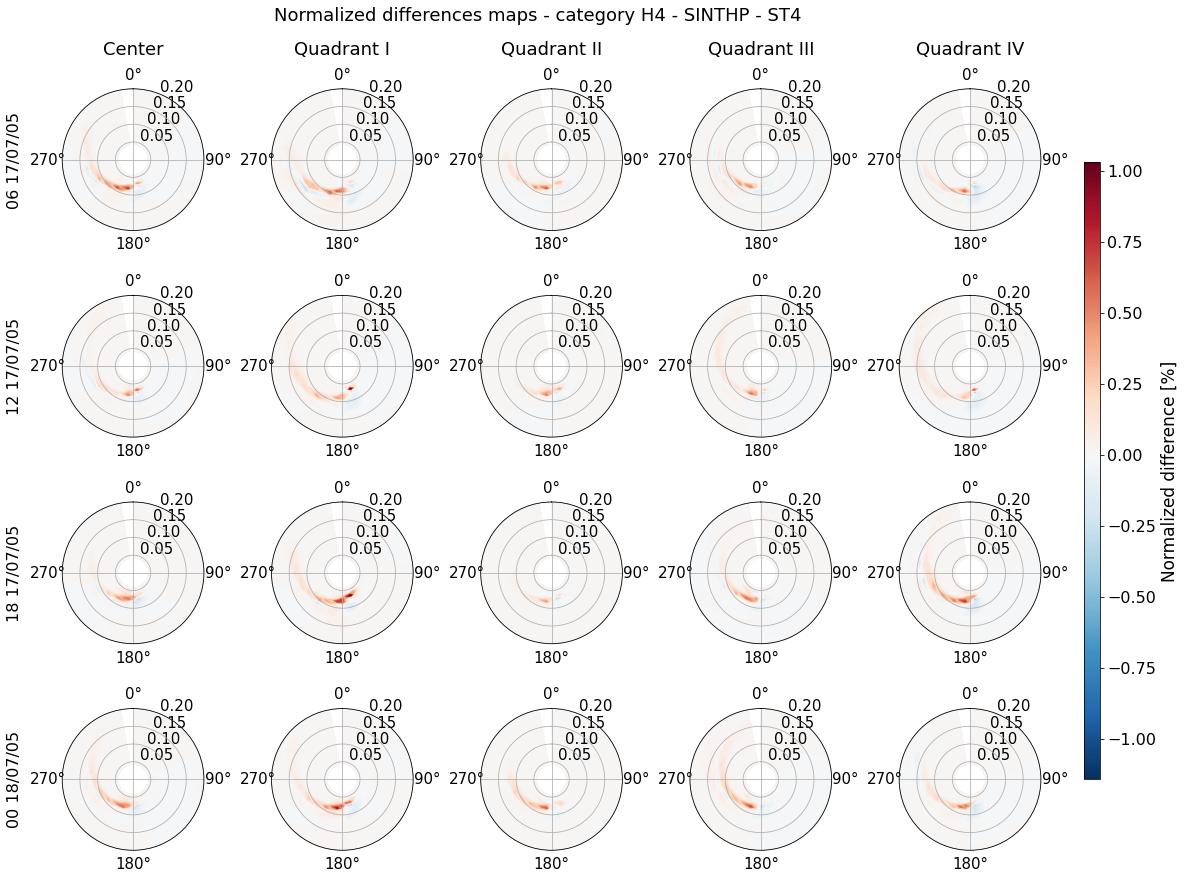

In [182]:
ap.plotting_diff_maps('H4')

In [212]:
class Integral_Plot(Advanced_Plot):
    def __init__(self,data_spec,dic_met,path_save):
      super().__init__(data_spec,dic_met,path_save)
      self.percents_num=[-0.5,-0.3,-0.1,0,0.1,0.3,0.5]
      self.parameter_list=np.unique(np.array(list(map(lambda x: x[:x.find ('/')],list(self.data_spec.keys())))))

    def intg_data_per_cat(self,param):
      self.results_array=np.zeros((5,5,7))
      for idx,cat in enumerate(self.cats):
        self.element=self.dic_met['dic_cats'][cat][0]
        for col in range(5):
          self.dic_met['idx_time']=self.element
          self.dic_met['quad']=col
          self.dic_met['name_param']=param
          obj=spec_data(specs_sw3,self.dic_met)
          self.dic_res=obj.computing_one()
          self.sorted_perc_dif_means=[self.dic_res['porc_means'][2],self.dic_res['porc_means'][1],self.dic_res['porc_means'][0],0,
                            self.dic_res['porc_means'][3],self.dic_res['porc_means'][4],self.dic_res['porc_means'][5]]     
          self.results_array[idx,col,:]=self.sorted_perc_dif_means
      return self.results_array


    def plot_intg(self):
      self.results_final_array=np.ones((len(self.parameter_list),5,5,7))
      for idx,param in enumerate(self.parameter_list):
        self.data=self.intg_data_per_cat(param)
        self.results_final_array[idx,:,:,:]=self.data

      for idx_cat in range(len(self.cats)):
        self.fig, self.axes = plt.subplots(nrows=1,ncols=5,figsize=(18,3.3),sharex=True,sharey=True)
        for col in range(5):
        # Plot for integral plot
          for idx_param,element in enumerate(self.parameter_list):
              self.axes[col].plot(self.percents_num,self.results_final_array[idx_param,idx_cat,col,:],'-o',label=element,lw=1.3,markersize=5)
              if col == 0:
                self.axes[col].set_xlabel('Parameter value')
                self.axes[col].set_ylabel('Norm. diff. of means [%]')
                self.axes[col].set_title('Center',y=1.05)
              elif 1<=col<=3:
                s='I'*col
                self.axes[col].set_title(f'Quadrant {s}',y=1.05)
              else:
                self.axes[col].set_title('Quadrant IV',y=1.05)
              self.axes[col].set_xticks(self.percents_num)
              self.labels=list(map(lambda x: str(int(x*100))+'%',self.percents_num))
              self.labels[3]=''
              self.axes[col].set_xticklabels(self.labels,rotation=30,fontsize=14)   

        self.axes[col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.suptitle('Normalized differences of means per quadrant - category '+self.cats[idx_cat]+ ' - '+self.dic_met['switch'],y=1.15,fontsize=18)
        plt.savefig(self.path_save+self.dic_met['switch']+'/integrals_plot/'+self.cats[idx_cat]+'.png',
                   dpi=1000,bbox_inches='tight',pad_inches=0.05)

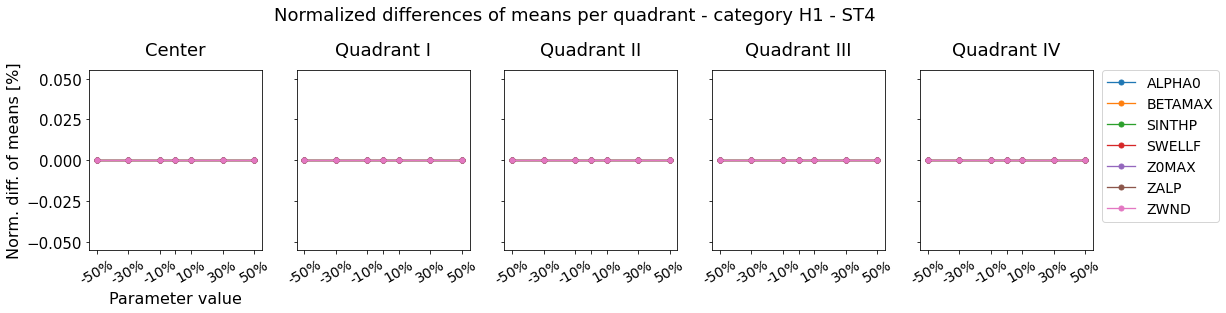

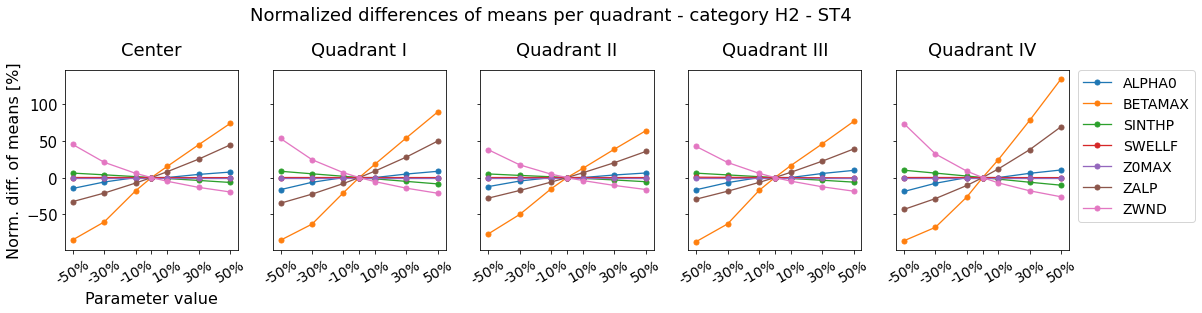

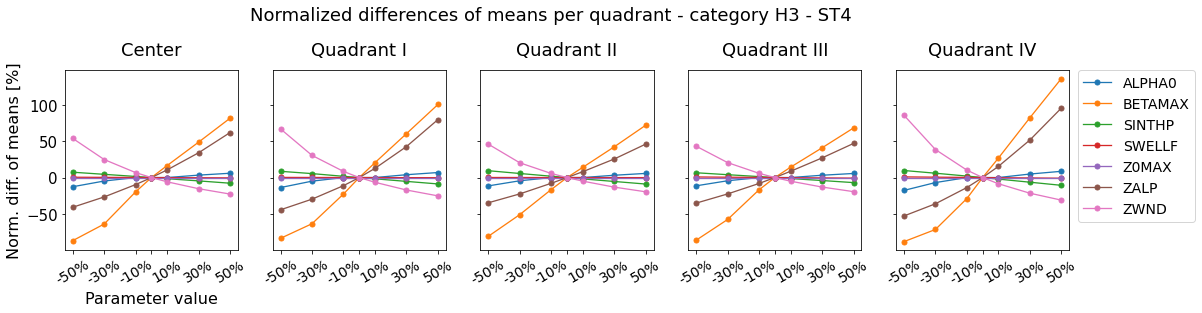

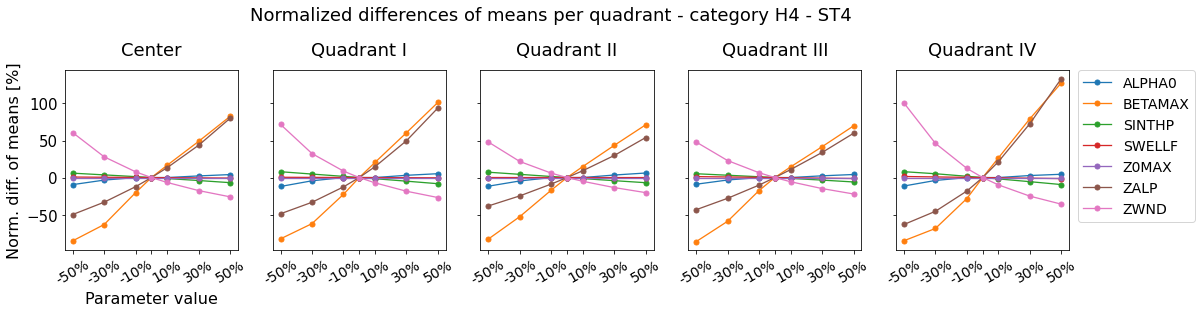

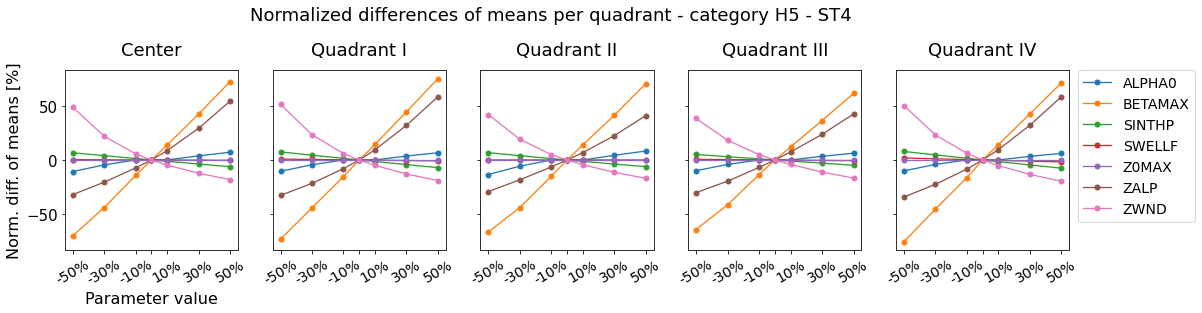

In [213]:
path_integral='/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/sensitivity analysis/plots/'
ip=Integral_Plot(specs_sw3,metadata,path_integral)
ip.plot_intg()

# Plotting the integral parameters

In [ ]:
ds_parts=np.load('/content/drive/Othercomputers/Mi PC/Tesis Maestria FranklinAyala/Scripts/Sensitivity analysis/hs_part.npz',
                 allow_pickle=True)

In [ ]:
hs_parts_sw3=ds_parts['sw3'].flatten()[0]

In [ ]:
to_plot2=hs_parts_sw3['ALPHA0/-50']